In [1]:
# # Mount to Google Drive to train on Colab
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/"SP22_ML_final_project"/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SP22_ML_final_project


In [2]:
#-----------------------------------------------------------------------#
#   predict.py将单张图片预测、摄像头检测、FPS测试和目录遍历检测等功能
#   整合到了一个py文件中，通过指定mode进行模式的修改。
#-----------------------------------------------------------------------#
import time

import cv2
import numpy as np
from PIL import Image

from yolo import YOLO

In [3]:
yolo = YOLO()
#----------------------------------------------------------------------------------------------------------#
#   mode用于指定测试的模式：
#   'predict'           表示单张图片预测，如果想对预测过程进行修改，如保存图片，截取对象等，可以先看下方详细的注释
#   'video'             表示视频检测，可调用摄像头或者视频进行检测，详情查看下方注释。
#   'fps'               表示测试fps，使用的图片是img里面的street.jpg，详情查看下方注释。
#   'dir_predict'       表示遍历文件夹进行检测并保存。默认遍历img文件夹，保存img_out文件夹，详情查看下方注释。
#   'heatmap'           表示进行预测结果的热力图可视化，详情查看下方注释。
#   'export_onnx'       表示将模型导出为onnx，需要pytorch1.7.1以上。
#----------------------------------------------------------------------------------------------------------#
mode = "video"
#-------------------------------------------------------------------------#
#   crop                指定了是否在单张图片预测后对目标进行截取
#   count               指定了是否进行目标的计数
#   crop、count仅在mode='predict'时有效
#-------------------------------------------------------------------------#
crop            = False
count           = False
#----------------------------------------------------------------------------------------------------------#
#   video_path          用于指定视频的路径，当video_path=0时表示检测摄像头
#                       想要检测视频，则设置如video_path = "xxx.mp4"即可，代表读取出根目录下的xxx.mp4文件。
#   video_save_path     表示视频保存的路径，当video_save_path=""时表示不保存
#                       想要保存视频，则设置如video_save_path = "yyy.mp4"即可，代表保存为根目录下的yyy.mp4文件。
#   video_fps           用于保存的视频的fps
#
#   video_path、video_save_path和video_fps仅在mode='video'时有效
#   保存视频时需要ctrl+c退出或者运行到最后一帧才会完成完整的保存步骤。
#----------------------------------------------------------------------------------------------------------#
video_path      = 0
video_save_path = ""
video_fps       = 25.0
#----------------------------------------------------------------------------------------------------------#
#   test_interval       用于指定测量fps的时候，图片检测的次数。理论上test_interval越大，fps越准确。
#   fps_image_path      用于指定测试的fps图片
#   
#   test_interval和fps_image_path仅在mode='fps'有效
#----------------------------------------------------------------------------------------------------------#
test_interval   = 100
fps_image_path  = "img/street.jpg"
#-------------------------------------------------------------------------#
#   dir_origin_path     指定了用于检测的图片的文件夹路径
#   dir_save_path       指定了检测完图片的保存路径
#   
#   dir_origin_path和dir_save_path仅在mode='dir_predict'时有效
#-------------------------------------------------------------------------#
dir_origin_path = "img/"
dir_save_path   = "img_out/"
#-------------------------------------------------------------------------#
#   heatmap_save_path   热力图的保存路径，默认保存在model_data下
#   
#   heatmap_save_path仅在mode='heatmap'有效
#-------------------------------------------------------------------------#
heatmap_save_path = "model_data/heatmap_vision.png"
#-------------------------------------------------------------------------#
#   simplify            使用Simplify onnx
#   onnx_save_path      指定了onnx的保存路径
#-------------------------------------------------------------------------#
simplify        = True
onnx_save_path  = "model_data/models.onnx"

logs/ep056-loss2.742-val_loss2.436.pth model, and classes loaded.


In [4]:
print(yolo.confidence)
print(yolo.nms_iou)
print(yolo.model_path)

0.7
0.6
logs/ep056-loss2.742-val_loss2.436.pth


In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
from PIL import Image
import io

In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [7]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  data = eval_js('takePhoto({})'.format(quality))
  img = js_to_image(data)
  img = Image.fromarray(np.uint8(img))
  img = np.array(yolo.detect_image(img))
  
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

b'without_mask 0.85' 260 286 447 450
Saved to photo.jpg


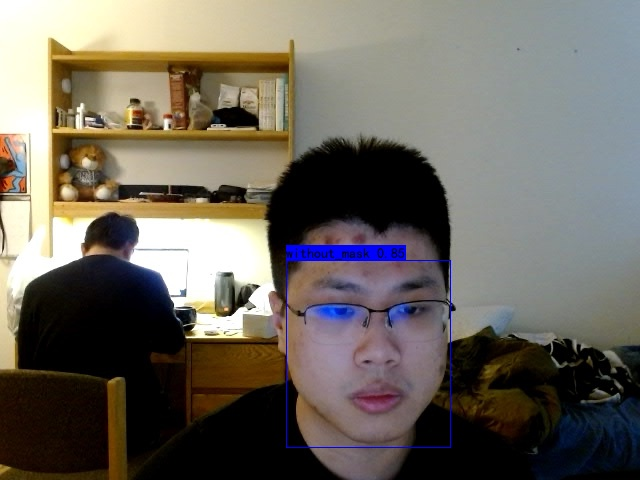

In [18]:
from IPython.display import Image as IMG
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(IMG(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
if mode == "predict":
    '''
    1、如果想要进行检测完的图片的保存，利用r_image.save("img.jpg")即可保存，直接在predict.py里进行修改即可。 
    2、如果想要获得预测框的坐标，可以进入yolo.detect_image函数，在绘图部分读取top，left，bottom，right这四个值。
    3、如果想要利用预测框截取下目标，可以进入yolo.detect_image函数，在绘图部分利用获取到的top，left，bottom，right这四个值
    在原图上利用矩阵的方式进行截取。
    4、如果想要在预测图上写额外的字，比如检测到的特定目标的数量，可以进入yolo.detect_image函数，在绘图部分对predicted_class进行判断，
    比如判断if predicted_class == 'car': 即可判断当前目标是否为车，然后记录数量即可。利用draw.text即可写字。
    '''
    while True:
        img = input('Input image filename:')
        try:
            image = Image.open(img)
        except:
            print('Open Error! Try again!')
            continue
        else:
            r_image = yolo.detect_image(image, crop = crop, count=count)
            r_image.show()

elif mode == "video":
    capture = cv2.VideoCapture(video_path)
    if video_save_path!="":
        fourcc  = cv2.VideoWriter_fourcc(*'XVID')
        size    = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        out     = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

    ref, frame = capture.read()
    if not ref:
        raise ValueError("未能正确读取摄像头（视频），请注意是否正确安装摄像头（是否正确填写视频路径）。")

    fps = 0.0
    while(True):
        t1 = time.time()
        # 读取某一帧
        ref, frame = capture.read()
        if not ref:
            break
        # 格式转变，BGRtoRGB
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        # 转变成Image
        frame = Image.fromarray(np.uint8(frame))
        # 进行检测
        frame = np.array(yolo.detect_image(frame))
        # RGBtoBGR满足opencv显示格式
        frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
        
        fps  = ( fps + (1./(time.time()-t1)) ) / 2
        print("fps= %.2f"%(fps))
        frame = cv2.putText(frame, "fps= %.2f"%(fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow("video",frame)
        c= cv2.waitKey(1) & 0xff 
        if video_save_path!="":
            out.write(frame)

        if c==27:
            capture.release()
            break

    print("Video Detection Done!")
    capture.release()
    if video_save_path!="":
        print("Save processed video to the path :" + video_save_path)
        out.release()
    cv2.destroyAllWindows()
    
elif mode == "fps":
    img = Image.open(fps_image_path)
    tact_time = yolo.get_FPS(img, test_interval)
    print(str(tact_time) + ' seconds, ' + str(1/tact_time) + 'FPS, @batch_size 1')

elif mode == "dir_predict":
    import os

    from tqdm import tqdm

    img_names = os.listdir(dir_origin_path)
    for img_name in tqdm(img_names):
        if img_name.lower().endswith(('.bmp', '.dib', '.png', '.jpg', '.jpeg', '.pbm', '.pgm', '.ppm', '.tif', '.tiff')):
            image_path  = os.path.join(dir_origin_path, img_name)
            image       = Image.open(image_path)
            r_image     = yolo.detect_image(image)
            if not os.path.exists(dir_save_path):
                os.makedirs(dir_save_path)
            r_image.save(os.path.join(dir_save_path, img_name.replace(".jpg", ".png")), quality=95, subsampling=0)

elif mode == "heatmap":
    while True:
        img = input('Input image filename:')
        try:
            image = Image.open(img)
        except:
            print('Open Error! Try again!')
            continue
        else:
            yolo.detect_heatmap(image, heatmap_save_path)
            
elif mode == "export_onnx":
    yolo.convert_to_onnx(simplify, onnx_save_path)
    
else:
    raise AssertionError("Please specify the correct mode: 'predict', 'video', 'fps', 'heatmap', 'export_onnx', 'dir_predict'.")